# CHSH inequality

-------
## 📘 पृष्ठभूमि (Background)

In this tutorial, we'll run an experiment on a quantum computer to demonstrate the violation of the CHSH inequality with the Estimator primitive.

The CHSH inequality, named after the arthors Clauser, Home, Shimony, and Holt, is used to experimentally prove Bell's theorem (1969). This theorem asserts that local hidden variable in quantum mechanics. The violation of the CHSH inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experment for understanding the foundation of quantum mechanics. 

The 2022 Nobel Prize for Physics was awarded to Alain Aspect, John Clauser and Anton Zeilinger in part for their pioneering work in quantum information science, and in particular, for their experiments woth entangled photons demonstrating violation of Bell's inequalties.

इस tutorial में हम एक quantum computer पर experiment करेंगे! 🔬 हमारा goal है CHSH inequality का violation दिखाना—with the help of Estimator primitive. 💡

👉 CHSH inequality, जिसका नाम Clauser, Horne, Shimony, और Holt के नाम पर है, एक important तरीका है जिससे हम Bell's theorem को experimentally prove करते हैं। Bell का theorem कहता है कि quantum duniya में “local hidden variables” काम नहीं करते।

🧪 CHSH inequality का violation ये बताता है कि quantum mechanics classical सोच से अलग है। यही तो इसकी खास बात है!

🎖️ 2022 का नोबेल पुरस्कार (भौतिकी के क्षेत्र में) Alain Aspect, John Clauser, और Anton Zeilinger को दिया गया था, खासतौर पर उनके quantum information science में अग्रणी कार्य के लिए। उन्होंने entangled photons (जुड़े हुए फोटॉनों) पर जो प्रयोग किए, उन्होंने Bell's inequalities का उल्लंघन दिखाया. 
***

## 🧰 Requirements

इस experiment के लिए आपको चाहिए:

* Qiskit SDK 1.X or more
* Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later
* Visulization suppport ('qiskit[visualization'])
  
  ****

  ## Setup
  



In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

### Step 1: Map classical inputs to a quantum problem
###        🎯 Classical दुनिया से Quantum circuit में mapping 🎯
For this experiment, we will create an entangled pair on which we measure each qubit on two different bases. We will label the bases for the first qubit A and a and the bases for the second qubit B and b. 

हम बनाएँगे एक entangled qubit pair और उन्हें दो अलग-अलग measurement bases में measure करेंगे:

- First qubit की bases: A और a
- Second qubit की bases: B और b

This allows us to compute the CHSH quantity $S_1$ :

$S_1 = A(B - b) + a(B + b).$

Each observable is either +1 or -1. Clearly, one of the terms B &plusmn; b must be 0, and the other must be &plusmn;2. Therefore, 
Observables होंगे +1 या -1 , तो एक term होगा 0 और दूसरा ±2 इसलिए:

The average value of $S_1$ must satisfy the inequality:
$$
|\langle S_1 \rangle| \leq 2
$$

Expanding S<sub>1</sub> in terms of A, a, B, and b results in:

$$
|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2

$$

You can define another CHSH quantity S<sub>2</sub> :

$$ S_2 = A(B + b) - a(B - b) , $$ 

This leads to another inequality:

$$
|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle | \leq 2
$$

If quantum mechanics can be described by local hidden variable thiories, the previous inequalities must hold true. However, as is demonstrated in this notebook, these inequalities can be violated in a quantum computer. Therefore, quantum mechanics is not compatible with local hidden variable theories.

अगर quantum duniya में सब कुछ local hidden variables से समझाया जा सकता हो, तो ये inequalities हमेशा valid होंगी ✅

पर हम साबित करेंगे कि ऐसा नहीं है! Quantum computer में इन inequalities को violate किया जा सकता है 🚀

We'll create an entangled pair between two qubits in a quantum computer by creating the Bell state 
$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

Using the Estimator primitive, we can directly obtain the expectation values needed 

🛠️ Estimator primitive का उपयोग ये हमें सीधे expectation values देता है:

($\langle AB \rangle$, $\langle Ab \rangle$, $\langle aB \rangle$, and $\langle ab \rangle$) to calculate the expectation values of the two CHSH quantities
($\langle S_1 \rangle$ and $\langle S_2 \rangle$).
Before the introduction of the Estimator primitive, we would have to construct the expection values from the measurement outcomes.

पहले हमें ये manually करना पड़ता था—अब Estimator से life आसान है 😄

### 🎛️ Measurement Angle Sweep 
We'll measure the second qubit in Z and X bases. The first qubit will be measured also in orthogonal bases, bur with and angle with respect to the second qubit, which we are going to sweep between 0 and $ 2\pi $. As we'll see, the Estimator primitive makes running parameterized circuits very easy. Rather than creating a series of CHSH circuits, we only need to create one CHSH circuit with a parameter specifying the measurement angle and a series of phase values for the parameter.

Second qubit को measure करेंगे Z और X bases में 🔄

First qubit को measure करेंगे orthogonal bases में—with an angle sweep from 0 to $2π$

Rather than multiple circuits, Estimator lets us use one parameterized CHSH circuit—और बस angles बदलते रहो! 🔁

### 📈 Results & Analysis
Finally, we'll analyze the results and plot them against the measurement angle. We'll see that for certain range of measurement angles, the expaction values of CHSH quantities $ |\langle S_1 \rangle | \gt 2 $ or $ |\langle S_2 \rangle | \gt 2$,
which demonstrate the violation of the CHSH inequality.

हम plot करेंगे expectation values vs. measurement angle 📊 और देखेंगे कि कुछ angles पर:
$ |\langle S_1 \rangle| > 2  या  |\langle S_2 \rangle| > 2 $
यानी violation मिल गया—that's the CHSH magic! 🌈🧠







In [2]:
# To run of hardware, select the backend woth the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_cloud")

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="QDcOPHdQw2So98jLrsy7gjR-hnNa6oPDZ4sPHV0bxBW1",
    instance="instance_satya",
    overwrite=True
)


print(service.backends())

backend = service.least_busy(
    operational = True, simulator = False, min_num_qubits=127 
)
backend.name

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


'ibm_torino'

### 🎛️ Parameterized CHSH Circuit बनाएँ (Create a Parameterized CHSH Circuit)

First, we write the circuit with the parameter $\theta$, which we call *theta*. The Estimator primitive can enormously simplify circuit building and output analysis by directly providing expectation values of observables. Many problems of interest, especially for near-term applications on noisy systems, can be formulated in terms of exoectation values. Estimator (V2) primitive can automatically chabge measurement basis based on the supplied observable.

इस सेक्शन में हम एक ऐसा circuit डिज़ाइन करेंगे जिसमें एक parameter θ (theta) होगा। Estimator primitive observables के expectation values सीधे निकालने में मदद करता है, और V2 version automatically measurement basis को observable के हिसाब से adjust कर देता है! 😎

मुख्य Steps:
- Bell state तैयार करना (H + CX) — दो qubits को entangle करना  
- पहले qubit पर θ angle के साथ basis rotation डालना (RY rotation)  
- दूसरे qubit को X-basis में मापने के लिए H gate apply करना  
- Barrier डालकर circuit को logical segments में विभाजित करना  

Estimator primitive हमें चार observables के expectation values (⟨AB⟩, ⟨Ab⟩, ⟨aB⟩, ⟨ab⟩) सीधे देता है। फिर इनसे हम CHSH quantities ⟨S₁⟩ और ⟨S₂⟩ निकालकर measurement angle के साथ plot कर सकते हैं।  

एक ही parameterized circuit में θ बदलते हुए पूरा angle sweep करना बिलकुल आसान हो जाता है—कोई अलग-अलग CHSH circuits बनाने की ज़रूरत नहीं! 🚀


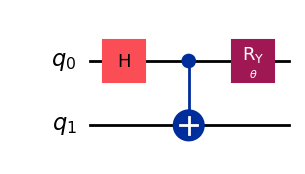

In [3]:
theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")


### 📑 Phase Values की लिस्ट बनाएँ (Create a List of Phase Values to Assign Later)

After creating the parameterized CHSH circuit, we'll creat a list of phase values to be assigned to the circuit in the next step. We can use the following code to create a list of 21 phase values range from 0 to 2 $\pi$ with equal spacing, that is, $0, 0.1\pi, 0.2\pi, ....,1.9\pi, 2\pi$. 

इस step में हम θ parameter के लिए 21 अलग-अलग phase values बनाएँगे, जो 0 से 2π तक बराबर-बराबर फैलें हों:

- शुरुआत: 0  
- अंत: 2π  
- कुल steps: 21 (0, 0.1π, 0.2π, …, 1.9π, 2π)  
- हर step की spacing: $ (\tfrac{2\pi - 0}{20} = 0.1\pi) $

इन phase values से हम पूरे angle sweep में circuit में θ बदलेंगे और CHSH quantities (⟨S₁⟩, ⟨S₂⟩) के expectation values को मापकर plot करेंगे। 🚀

---


In [4]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order
individual_phases = [[ph] for ph in phases]

### Observables

Now we need observables from which to compute the expectation values. In our case we are looking at orthogonal bases for each qubit, letting the parameterized Y- rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables ZZ, ZX, XZ, and XX.

### 👀 Observables चुनें (Observables)

अब हम उन observables को define करेंगे जिनसे हमें expectation values मिलेंगी। हमारे experiment में हम दोनों qubits के लिए orthogonal bases में measurements कर रहे हैं, जहाँ first qubit पे parameterized Y-rotation से basis sweep होगा और second qubit के लिए Z/X bases फिक्स रहेंगे।  

इसलिए हम चुनते हैं ये चार observables:

- **Z Z**: दोनों qubits को Z-basis में measure करना  
- **Z X**: पहला qubit Z-basis, दूसरा qubit X-basis में measure करना  
- **X Z**: पहला qubit X-basis, दूसरा qubit Z-basis में measure करना  
- **X X**: दोनों qubits को X-basis में measure करना  

इन observables से हमें  
⟨ Z Z ⟩, ⟨ Z X ⟩, ⟨ X Z ⟩, और ⟨ X X ⟩  
की values मिलेंगी, जिनसे हम CHSH quantities ⟨S₁⟩ और ⟨S₂⟩ calculate करेंगे। 🚀


In [5]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)]
)

# <CHSH2> =<AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)]
)

## 🔧 Step 2: क्वांटम हार्डवेयर execution के लिए समस्या optimize करें (Optimize for Quantum Hardware execution)

To reduce the total job execution time, V2 primitives only accept circuits and observables that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).



हर quantum hardware की अपनी ISA (Instruction Set Architecture) होती है — एक स्पेसिफिक gate-set और qubit coupling map। V2 primitives केवल उन circuits और observables को स्वीकार करते हैं जो इन ISA constraints को पूरा करते हों, ताकि job execution समय कम रहे और resource efficient compilation हो।

ISA constraints:

- Gate support  
  target device पर उपलब्ध single-qubit और two-qubit gates (जैसे U, CNOT)

- Qubit connectivity  
  qubits के बीच coupling map और allowed CNOT directions

- Measurement basis translations  
  observables को hardware-native measurement settings में automatically बदलना

इन optimizations से हमें मिलता है:  

- तेज़ transpilation और reduced compilation time ⏱️  
- hardware resources का बेहतर उपयोग 🔄  
- execution latency और noise impact में कमी 🎯  


### ISA Circuit

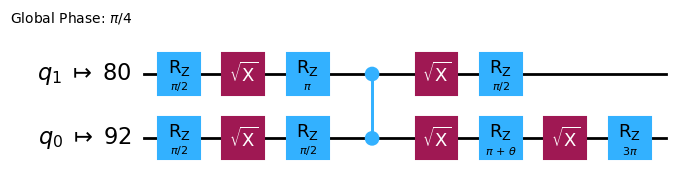

In [6]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### 🔄 ISA Observables

Similarly, we need to transform the observables to make it backend compatible before running jobs with *Runtime Estimator V2* . We can perform the transformation using the *apply_layout* the method of SparsePauliOp object.

Runtime Estimator V2 से jobs चलाने से पहले observables को backend-compatible ISA format में transform करना ज़रूरी है।  

SparsePauliOp object का apply_layout method qubit layout और coupling constraints के हिसाब से observables को re-map कर देता है।

मुख्य steps:

- observables को device-specific qubit ordering में map करना  
- apply_layout से Pauli operators को सही qubit indices assign करना  
- measurement basis translations और coupling-directions सुनिश्चित करना  

इस transformation के बाद आप observables को सीधे target hardware पर चला सकते हैं—कोई manual re-mapping नहीं करनी पड़ेगी! 🚀  


In [7]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)


## 🚀 Step 3: Qiskit primitives से Execution करें (Execute Using Qiskit Primitives)

In order to execute the entire experiment in one call to the Estimator.
We can create a Qiskit Runtime Estimator primitive to compute our expectation values. The EstimatorV2.run() method takes an iterable of primitive unified blocs 
(PUBs) . Each PUB is an iterable in the format (circuit, observables , parameter_values: Optional, precision:Optional) .

अब हम पूरे experiment को एक ही Estimator कॉल में execute करेंगे! 🎯 इसके लिए हम बनाएँगे एक **Qiskit Runtime Estimator primitive** जो expectation values को directly compute करता है।

### 📦 EstimatorV2 का उपयोग (Using EstimatorV2)

EstimatorV2 का `.run()` method एक iterable लेता है जिसे कहते हैं **Primitive Unified Blocs (PUBs)**.

हर PUB इस format में होता है:

```text
(circuit, observables, parameter_values (optional), precision (optional))

circuit: हमारा parameterized CHSH quantum circuit

observables: जो हमने backend-compatible बनाकर transform किए थे

parameter_values: θ के लिए phase values (जैसे 0, 0.1π … 2π)

precision: optional parameter, जिससे results की statistical accuracy तय होती है

Estimator primitive backend की ISA को ध्यान में रखते हुए circuits को run करता है और observables की expectation values तुरंत उपलब्ध करा देता है—बिना extra measurements या classical postprocessing के। 🔍

अब हम तैयार हैं circuit को execute करने, Estimator के जादू से expectation values निकालने, और CHSH violation को graphically analyze करने! 🌈


In [8]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.

estimator = Estimator(mode=backend)

pub = (
    chsh_isa_circuit, # ISA circuit
    [[isa_observable1], [isa_observable2]], # ISA observables
    individual_phases, # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()


## 📊 Step 4: Classical Format में Result को Post-process करें (Post-process and return result in desired classical format)

The estimator rerurns expectation values for both of the observables,

अब जब Estimator ने observables के लिए expectation values दे दी हैं, हम उन्हें classical format में convert करेंगे जिससे CHSH quantities की गणना की जा सके।

Estimator हमें निम्न दो expressions के लिए values देता है:

$$
\langle ZZ \rangle - \langle ZX \rangle + \langle XZ \rangle + \langle XX \rangle and \langle ZZ \rangle + \langle ZX \rangle - \langle XZ \rangle + \langle XX \rangle

$$
इन दोनों expressions से हम यह verify कर सकते हैं कि क्या:

⟨S₁⟩ > 2 या

⟨S₂⟩ > 2

📈 अगर ऐसा होता है, तो CHSH inequality का violation साबित हो जाता है—यानी quantum mechanics local hidden-variable theories से मेल नहीं खाती।

---
अब हम इन results को phase angle के against plot करके graphically analyze करेंगे—तैयार हो जाइए quantum स्पेस में थोड़ा classical magic देखने के लिए! ✨🔍


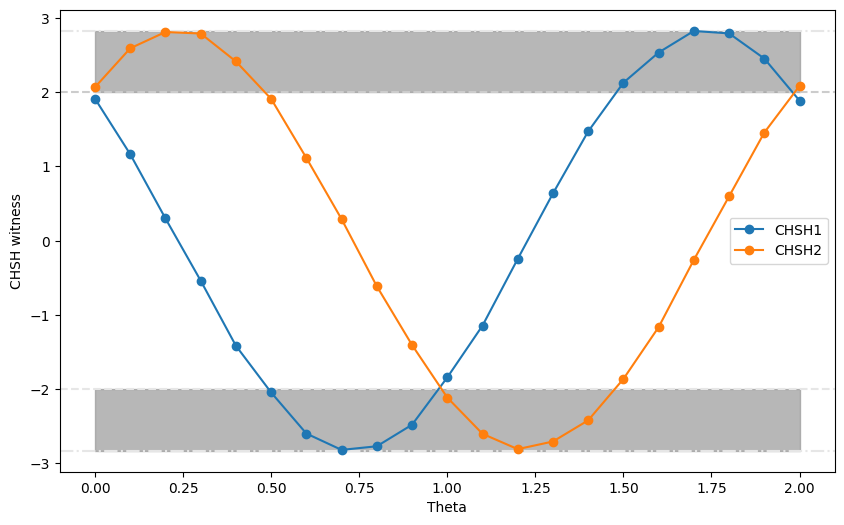

In [9]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +- 2
ax.axhline(y=2, color="0.8", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()


In the figure, the lines and gray areas delimit the bounds; the outer-most (dasho=dotted) lines delimit the quantum-bounds $ (\plusmn 2) $, whereas the inner (dashed) lines delimit the classical bounds $(\plusmn 2\sqrt 2)$. We can see that there are regions where the CHSH witness quantities exceeds the classical bounds. 
Congratulations! We have successfully demonstrated the violation of CHSH inequality in a real quantum system!

## 🎉 CHSH Violation Confirmed! (निष्कर्ष)

इस figure में आप देख सकते हैं:

- Outer-most dotted lines represent **Quantum bounds** \((\pm 2)\)  
- Inner dashed lines show **Classical bounds** \((\pm 2\sqrt{2})\)  
- Gray shaded area → region between classical and quantum limits

📈 कुछ जगहों पर CHSH witness quantity classical bounds से ऊपर जाती है — यानी:

$$
|\langle S \rangle| > 2\sqrt{2}

$$
👉 इसका मतलब है कि हमने classical physics की limitations को पार कर लिया है — और quantum mechanics की non-locality को live demonstrate किया है!

🥳 बधाई हो! आपने सफलतापूर्वक CHSH inequality को violate किया — एक असली quantum hardware पर experiment करके!

यह एक ज़बरदस्त achievement है, खासकर young learners के लिए जो quantum सोच को शुरू में समझने की कोशिश कर रहे हैं।

अब अगला कदम हो सकता है:

Measurement noise का प्रभाव देखना

Entanglement fidelity को evaluate करना

और Bell’s theorem की deeper analogies explore करना

Quantum विज्ञान अब सिर्फ किताबों की बात नहीं रही—आपने उसे हकीकत में जी लिया है। 🚀💫